In [39]:
import os
import geopandas as gpd
import pandas as pd
from shapely import wkt
import glob
from typing import Optional, Union, Dict, List, Any
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline

In [8]:
def csv_conversion(csv_path, crs='EPSG:4326', dtypes=None):
    """
    Convert a CSV file to a geodataframe
    """
    df = pd.read_csv(csv_path, dtype=dtypes)
    # Convert the geometry column to a geodataframe
    gdf = gpd.GeoDataFrame(df, geometry=df['geometry'].apply(wkt.loads), crs=crs)

    return gdf
    

In [28]:
csv_path = r'D:\Projects\superparcels\data\abreunig_pocs_spatialrecord_polygon_superparcel_rural.csv'
output_dir = r'D:\Projects\superparcels\data\Rural'


In [29]:
df = csv_conversion(csv_path, dtypes={'FIPS': str})
county_names = {
    '06075': 'San_Fran_CA',
    '06001': 'Alameda_CA',
    '08031': 'Denver_CO',
    '48113': 'Dallas_TX',
    '41013': 'Crook_OR',
    '20097': 'Kiowa_KS',
    '55107': 'Rusk_WI',
    '35051': 'Sierra_NM',

}
fips = df['FIPS'].unique()


In [11]:
for fid in fips:
    print(fid)
    df_fid = df[df['FIPS'] == fid]
    fid_dir = os.path.join(output_dir, county_names[fid])
    if not os.path.exists(fid_dir):
        os.makedirs(fid_dir)

    df_fid.to_file(os.path.join(fid_dir, f'sp_sample_{fid}.shp'))

array(['06075', '08031', '06001', '48113'], dtype=object)

### Remove duplicate geometries and find canidate parcels for clustering POC

In [11]:

def classify_duplicates(df, fields):
    """
    Classifies the rows of a DataFrame based on duplicate status for any number of fields.

    Parameters:
    df (pd.DataFrame): DataFrame containing the data.
    fields (list of str): List of column names to check for duplicates.

    Returns:
    pd.Series: Value counts of each classification.
    """
    # Identify duplicates for each field and store in a new column
    for field in fields:
        df[f'duplicate_{field}'] = df.duplicated(subset=[field], keep=False)

    # Create a classification column based on the duplication status of each field
    def classify_row(row):
        classification = []
        for field in fields:
            if row[f'duplicate_{field}']:
                classification.append(f'Duplicate {field}')
            else:
                classification.append(f'Unique {field}')
        return ', '.join(classification)

    df['classification'] = df.apply(classify_row, axis=1)
    df['classify_codes'] = df['classification'].astype('category').cat.codes

    # Count the occurrences of each classification
    return df


In [12]:
def codes_to_shp(df, id_field: str, code_field: str, cluster_canidate_codes: Optional[List] = []):
    """
    Convert a DataFrame to a shapefile based on classification codes.

    Parameters:
    df (pd.DataFrame): DataFrame containing the data.
    id_field (str): Name of the field to use as the unique identifier.
    code_field (str): Name of the field containing the classification codes.
    cluster_canidate_codes (list of int): List of classification codes to use as cluster candidates.
    """

    for code in class_codes:
        gdf = df[df[code_field] == code]
        gdf.to_file(os.path.join(data_dir, f'sp_sample_{id_field}_{code}.shp'))

    for code in cluster_canidate_codes:
        gdf = df[df[code_field] == code]
        gdf.to_file(os.path.join(data_dir, f'sp_sample_{id_field}_cluster_candidates.shp'))

    return

In [30]:
fips

array(['55107', '20097', '41013', '35051'], dtype=object)

In [40]:
#cmap = mcolors.ListedColormap(['red', 'blue'])

Processing 55107
Processing 20097
Processing 41013
Processing 35051
classification
Unique OWNER, Unique geometry       5516
Duplicate OWNER, Unique geometry    4013
Name: count, dtype: int64


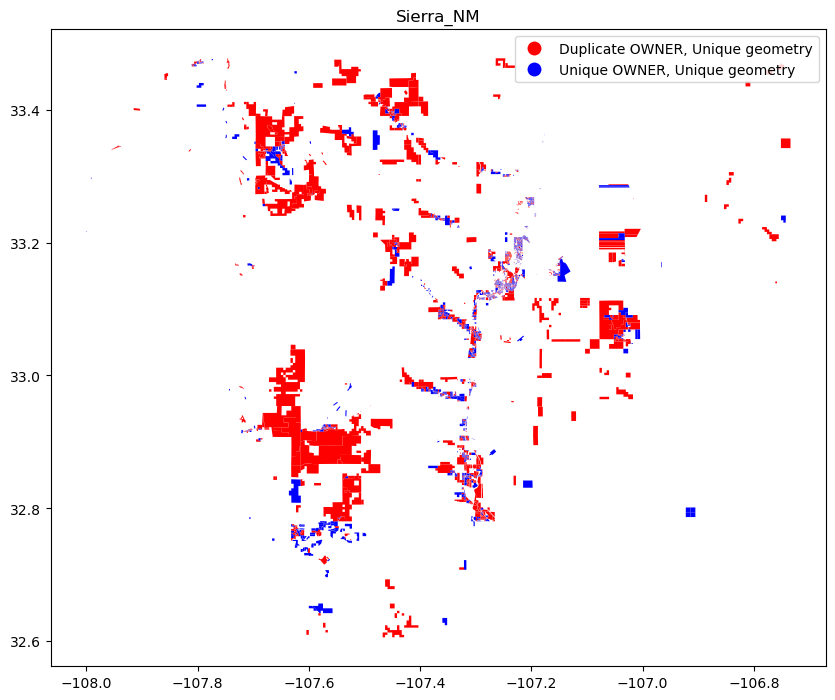

In [49]:
for fid in fips:
    print(f'Processing {fid}')
    if fid != '35051':
        continue
    county_name = county_names[fid]
    file_path = os.path.join(output_dir, f'{county_name}\sp_sample*.shp')

    if len(glob.glob(file_path)) == 0:
        print(file_path)
        continue

    df = gpd.read_file(glob.glob(file_path)[0])

    df = classify_duplicates(df, fields=['OWNER', 'geometry'])
    print(df['classification'].value_counts())
    #print(df['classify_codes'].value_counts())
    # visualize the data using matplotlib
    fig, ax = plt.subplots(figsize=(10, 10))
    df.plot(column='classification', ax=ax, legend=True, cmap=cmap)
    ax.set_title(f'{county_name}')
   

    plt.show()
    break
    canidate_df = df[df['classification'] == 'Duplicate OWNER, Unique geometry']

    codes_to_shp(df, id_field='FIPS', code_field='classify_codes', cluster_canidate_codes=canidate_df['classify_codes'].unique())
    print('_____________________________')

In [ ]:
 # add legend
    # plot the data where duplicate owner, unique geometry is red and unique owner, duplicate geometry is blue
    df[df['classification'] == 'Duplicate OWNER, Unique geometry'].plot(ax=ax, color='red', label='Duplicate OWNER, Unique geometry', legend=True)
    df[df['classification'] == 'Unique OWNER, Unique geometry'].plot(ax=ax, color='blue', label='Unique OWNER, Duplicate geometry', legend=True)
    
    # add a title
    ax.set_title(f'{county_name}')